In [6]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
from util.league_table import generate_league_table
from util.elo_calculator import initialize_team_stats, calculate_elo_ratings, loss_from_comparing_tables, elo_grid_search, brier_scores_by_matchweek

from statsbombpy import sb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Load data
competitions = load_competitions()
matches = load_matches(competition_id=9, season_id=27)
#matches = load_matches(competition_id=9, season_id=281)

c:\Users\mathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [19]:
# Generate league table
final_table = generate_league_table(matches)
final_table

,team,Matches,Wins,Draws,Losses,Goals_For,Goals_Against,Points,Goal_Difference
0,Bayern Munich,34,28,4,2,80,17,88,63
1,Borussia Dortmund,34,24,6,4,82,34,78,48
2,Bayer Leverkusen,34,18,6,10,56,40,60,16
3,Borussia Mönchengladbach,34,17,4,13,67,50,55,17
4,Schalke 04,34,15,7,12,51,49,52,2
5,FSV Mainz 05,34,14,8,12,46,42,50,4
6,Hertha Berlin,34,14,8,12,42,42,50,0
7,Wolfsburg,34,12,9,13,47,49,45,-2
8,FC Köln,34,10,13,11,38,42,43,-4
9,Hamburger SV,34,11,8,15,40,46,41,-6


# 1 Team and Player Strength Models
##  1.0.1 Task 1: ELO rating

### Part 1: Developing an Elo Model 
The following Elo Model developped in elo_calculator.py with arbitrary Hyperparameters k and s. 

Using a loss function that compares the placements of the elo standings after the season to the actual Bundesliga 15/16 results we quantify how good the elo model predicts final standings. Here, the combined missplaccements add up to 12 - not bad for a start.

In [20]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=15, SCALING_FACTOR = 400, HOME_ADVANTAGE=0.00, STARTING_ELO=1000.)
print (loss_from_comparing_tables(final_table,team_stats))

12


### Part 2: Using R0 = 100, k = 15 and s = 15

This task asks us to set the initial rating to 100, K to 15 and the scaling parameter s to 15.

Printing out the loss shows us that was a rather poor performance. We suspect the parameter s to be the cause of this but we will see in the later course of the project if that is the case.



In [21]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=15, SCALING_FACTOR = 15, HOME_ADVANTAGE=0.00, STARTING_ELO=100.)
print (loss_from_comparing_tables(final_table,team_stats))

82


### Part 3: finding the optimal parameters

Now to start off, the loss function we developed is nice, but a bit too simple. So from now on we will implement the brier score.

The brier score computes a value between 0 and 1 to quantify how well our elo model predicts the match. The lower the score, the better. It uses a probability vector of in this case 3 dimensions and compares it to the actual outcome of the match. We do this for every match and average out per matchday and season.

Now elo models do not yield probabilities so we first have to convert the elo ratings to probabilities using a threeway probability model that makes use of three additional hyperparameters. 

- alpha has a direct relationship with the scaling parameter s so we technically dont need to tune it.
- beta controls how much probability mass is given to draws. The higher we set it the more likely the draws get. So for a sport like basketball where draws are rather unusual we would set beta to a drastically different value than for football.
- gamma controls how quickly draw probabilities decrease as the elo gap between the teams increases.

We now use a parameter grid search model to find all the optimal parameters. We will spare you all the different trys we had, but after a long search we found the optimal parameters which yield a brier score of around 0.58 .

In [24]:
param_grid = {
    'K_FACTOR': [1],#np.arange(1.,7.,1.), 
    'SCALING_FACTOR': np.arange(10.,51.,10.),
    'HOME_ADVANTAGE': [0.01] ,#np.arange(0.01,0.10,0.05),
    'STARTING_ELO': np.arange(500.,2501.,500.),
    'beta' : np.arange(-2.,2.,0.5),
    'gamma' : np.arange(0.0,0.9,0.05)
}


# np.arrange

# Returns best Hyperparameters, best Score and Dataframe of all Combinations with their respective Score
best_params, best_score, all_results = elo_grid_search(matches, param_grid)

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'K_FACTOR': 1, 'SCALING_FACTOR': 40.0, 'HOME_ADVANTAGE': 0.01, 'STARTING_ELO': 1500.0, 'beta': 0.0, 'gamma': 0.1}
Best Score: 0.5866876497504424


The following shows a quick visualisation of the grid search above. Sadly, our poor human mind cannot comprehend more than 3 dimensions so we had to choose to show the three parameters that in our opinion had the greatest impact on the brier score.

And for completeness, we also visualize the final elo standings.

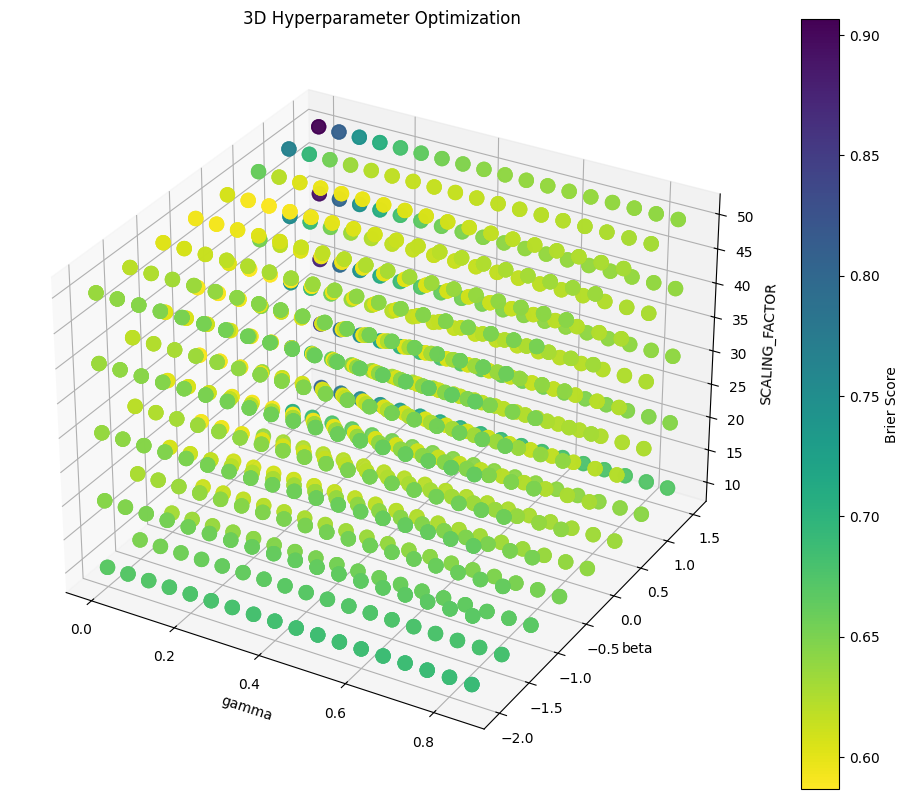

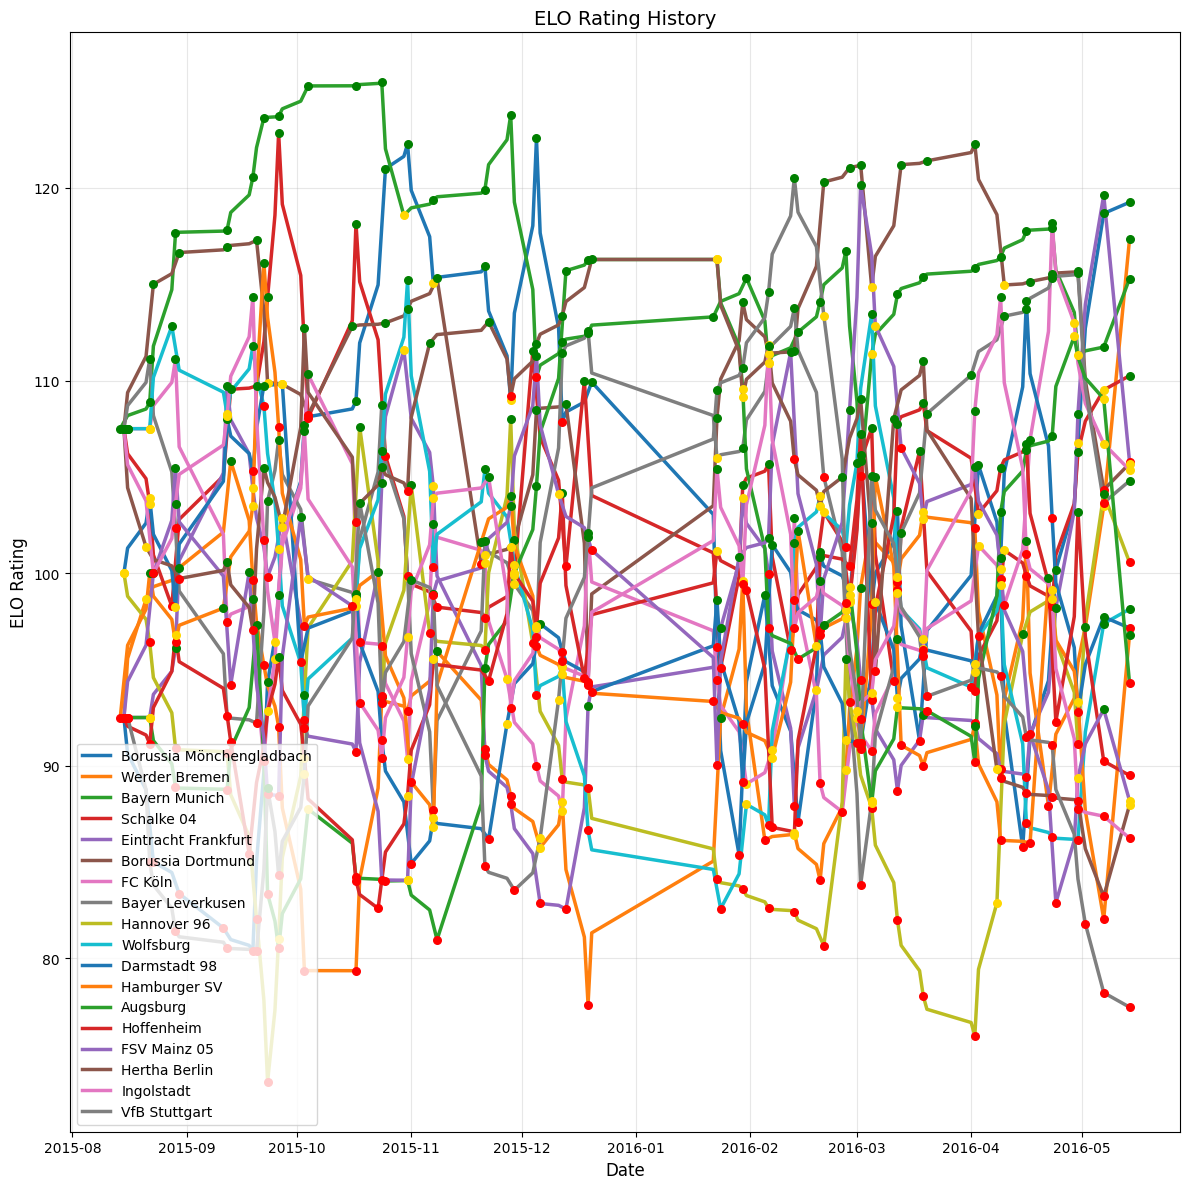

In [25]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
scatter = ax.scatter(
    all_results["gamma"],
    all_results["beta"],
    all_results["SCALING_FACTOR"],
    c=all_results["loss"],
    cmap="viridis_r",
    s=100,
)

ax.set_xlabel("gamma")
ax.set_ylabel("beta")
ax.set_zlabel("SCALING_FACTOR")
plt.colorbar(scatter, label="Brier Score")
plt.title("3D Hyperparameter Optimization")
plt.show()

selected_teams = team_stats['team'].tolist()
team_history = elo_history_df

elo_pivot = team_history.pivot(index='date', columns='team', values='elo')
elo_pivot = elo_pivot.sort_index().interpolate()

plt.figure(figsize=(12, 12))

result_colors = {'win': 'green', 'loss': 'red', 'draw': 'gold'}

for team in selected_teams:
    plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5)

    team_points = team_history[team_history['team'] == team]
    for _, row in team_points.iterrows():
        plt.scatter(row['plot_date'], row['elo'], color=result_colors[row['result']], s=30, zorder=5)


plt.title('ELO Rating History', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()



### Part 4: most/least Surpising Wins/Losses

The following shows a small and quick approach to find the most and least surprising wins of the season.

We found that the most surprising match outcome was Eintracht Frankfurt 1 : 0 Borussia Dortmund on Matchday 33, which makes sense since Frankfurt were at the verge of getting directly relegated while Dortmund were sitting at Position 2 in the table. 

The least surprising match was between Werder Bremen 0 : 1 Bayern München on the same matchday. This one also makes sense as Bayern was sitting top of the table, already deemed German Champions, while Bremen was fighting relegation along with Frankfurt.

Now while these findings make sense to us, we will later see why they might not be quite right.

In [26]:
# Get the most surpising wins/losses 
max_difference = elo_history_df['elo_diff'].abs().max()
rows_with_max_difference = elo_history_df[elo_history_df['elo_diff'].abs() == max_difference]
most_surprising_matches = matches[matches['match_id'].isin(rows_with_max_difference['match_id'].unique())]
most_surprising_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_week,competition_stage,stadium,referee,home_managers,away_managers
115,3890460,2016-02-27,16:30:00.000,Germany - 1. Bundesliga,2015/2016,VfB Stuttgart,Hannover 96,1,2,23,Regular Season,Mercedes-Benz-Arena,Sascha Stegemann,Jürgen Kramny,Thomas Schaaf


In [27]:
# Get the least surpising wins/losses 
elo_history_without_draws = elo_history_df[elo_history_df['result'] != 'draw']
min_difference = elo_history_without_draws['elo_diff'].abs().min()
rows_with_min_difference = elo_history_without_draws[elo_history_without_draws['elo_diff'].abs() == min_difference]
least_surprising_matches = matches[matches['match_id'].isin(rows_with_min_difference['match_id'].unique())]
least_surprising_matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_week,competition_stage,stadium,referee,home_managers,away_managers
236,3890332,2015-10-17,15:30:00.000,Germany - 1. Bundesliga,2015/2016,Werder Bremen,Bayern Munich,0,1,9,Regular Season,Wohninvest Weserstadion,Christian Dingert,Viktor Skripnik,Josep Guardiola i Sala


### Part 5: (optional part) Same task but using a Glicko model instead of Elo.

In this part we would have used a Glicko model instead of an Elo one, but since this one was optional in the Proposal we decided not to implement it for the simple reason of not thinking it would differ much from the Elo model in terms of prediction accuracy. It does not take into account real life factors either so our findings would be very similar to the Elo results (see Part 6).

# No Part, just Plot of ELO Grid

In [28]:
team_stats, elo_history_df = calculate_elo_ratings(matches, K_FACTOR=1, SCALING_FACTOR = 40.0, HOME_ADVANTAGE=0.00, STARTING_ELO=1000.)

print (loss_from_comparing_tables(final_table,team_stats))

8


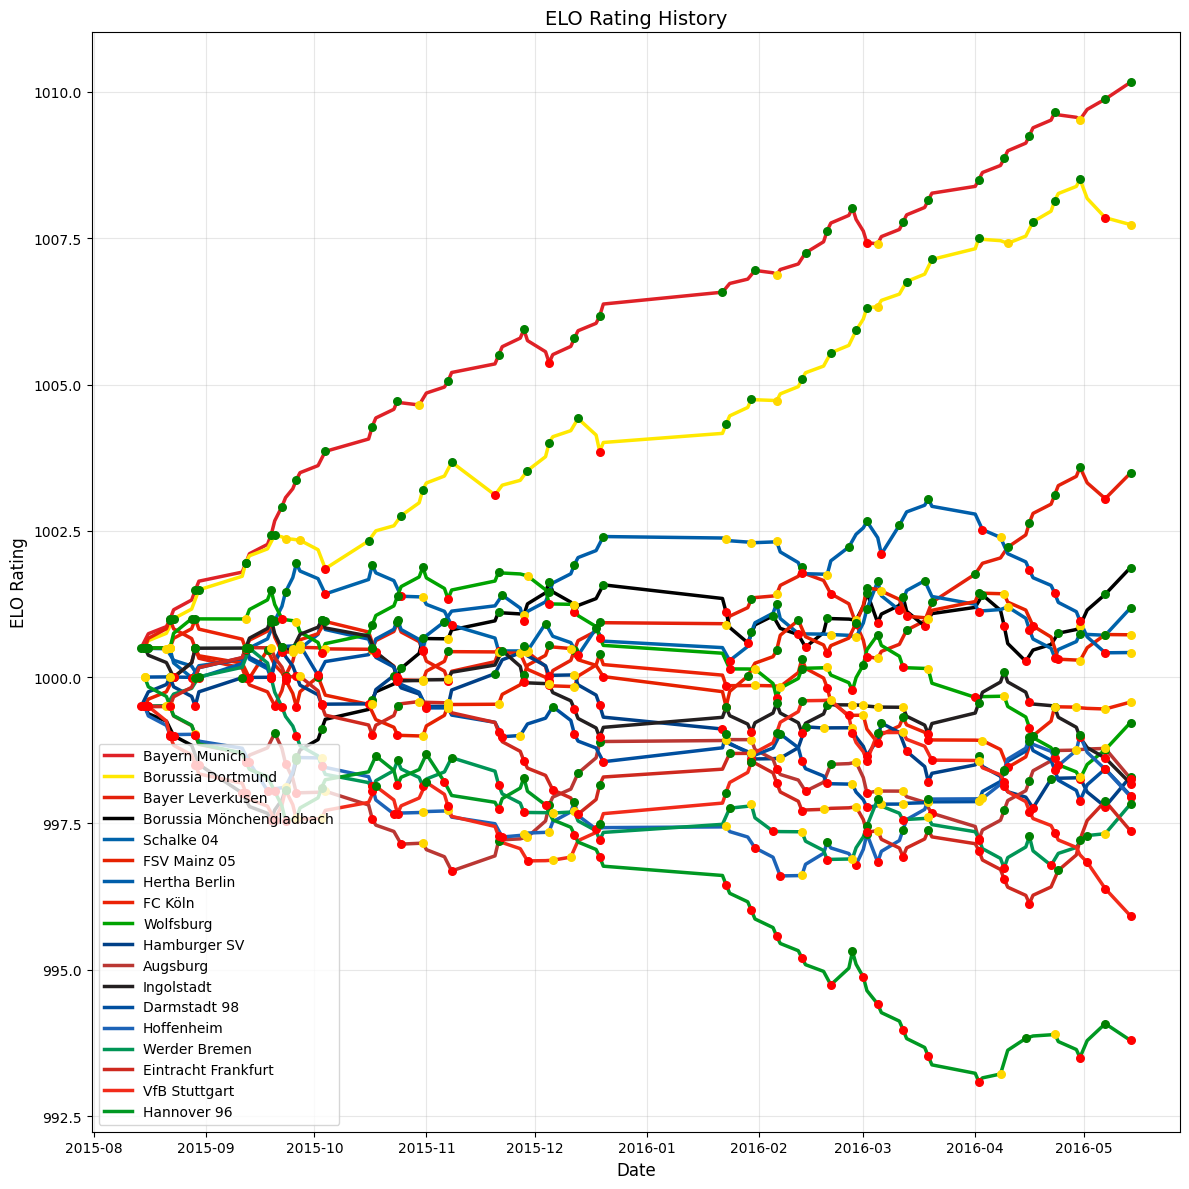

In [37]:
team_colors = {
    'Bayern Munich': '#df2127',
    'Borussia Dortmund': '#ffe800',
    'Darmstadt 98': '#004F9F',
    'Hoffenheim': '#1c63b7',
    'FC Köln' : '#eb2206',
    'Hertha Berlin' : '#005eaa',
    'Werder Bremen' : '#009556',
    'Bayer Leverkusen' : '#e4210b',
    'Borussia Mönchengladbach' : '#000000',
    'Augsburg' : '#ba3733',
    'Ingolstadt' : '#231F20',
    'Eintracht Frankfurt' : '#ce291f',
    'Hamburger SV' : '#004087',
    'FSV Mainz 05' : '#e62100',
    'VfB Stuttgart' : '#f22b1a',
    'Hannover 96' : '#009822',
    'Wolfsburg' : '#00a300',
    'Schalke 04' : '#0063aa',
}
selected_teams = team_stats['team'].tolist()
team_history = elo_history_df

elo_pivot = team_history.pivot(index='date', columns='team', values='elo')
elo_pivot = elo_pivot.sort_index().interpolate()

plt.figure(figsize=(12, 12))

result_colors = {'win': 'green', 'loss': 'red', 'draw': 'gold'}

for team in selected_teams:
    color = team_colors.get(team, None)
    plt.plot(elo_pivot.index, elo_pivot[team], label=team, linewidth=2.5, color = color )

    team_points = team_history[team_history['team'] == team]
    for _, row in team_points.iterrows():
        plt.scatter(row['plot_date'], row['elo'], color=result_colors[row['result']], s=30, zorder=5)


plt.title('ELO Rating History', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# Part 6: Summarized approach and findings

As seen above, we used an ELO model to predict the future outcome of matches and the brier score then told us how well we did.

The best score we found was 0.58, but how good is that score in reality? 

Let's say we randomly guessed each match outcome at random with a respective probability vector of [0.33,0.33,0.33]. This approach would then yield us a brier score of 0.66 . Now while our model has a lower brier score, it is not significantly lower and to be quite frankly honest, a bit disappointing. But what caused this result? To understand what happened we need to look at the brier score per matchday and the probabilitiy vector for each match.

   match_week  brier_score
0           1     0.475526
1           2     0.522180
2           3     0.516911
3           4     0.538768
4           5     0.457781
0.5866460875406814


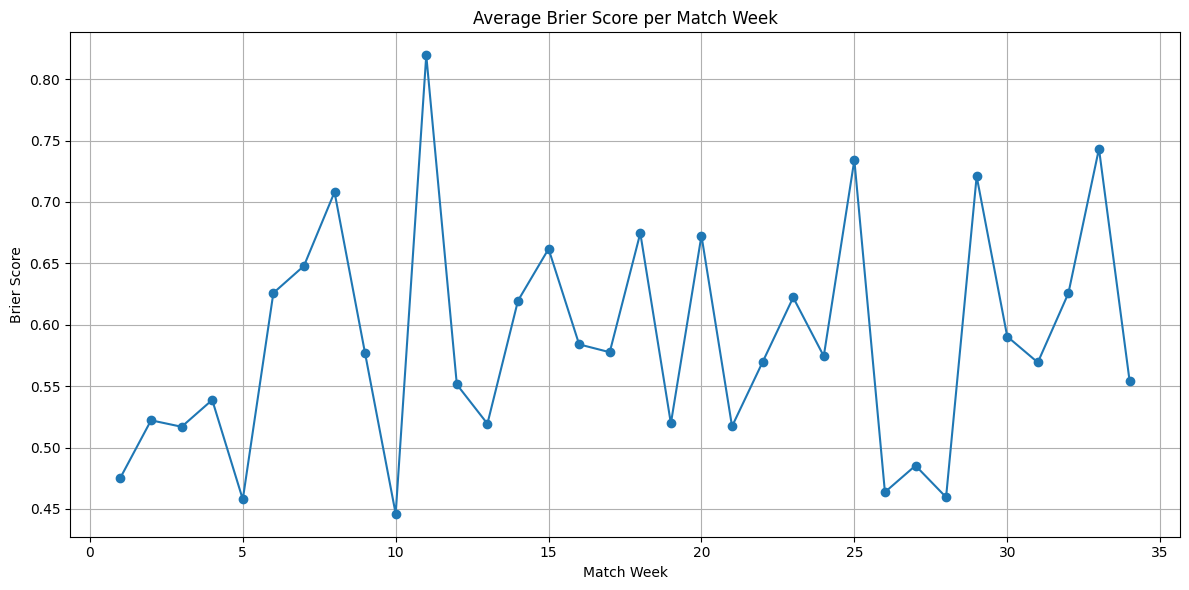

,match_id,p_home,p_draw,p_away
0,3890259,0.757910,0.103091,0.138999
1,3890265,0.308754,0.283886,0.407361
2,3890260,0.543481,0.209853,0.246667
3,3890264,0.286529,0.255945,0.457526
4,3890262,0.490051,0.238256,0.271693
...,...,...,...,...
301,3890559,0.914944,0.032613,0.052442
302,3890560,0.269900,0.236164,0.493937
303,3890562,0.714418,0.123843,0.161739
304,3890563,0.572719,0.194631,0.232650


In [30]:
weekly_brier,match_probs,elobrier = brier_scores_by_matchweek(matches,K=1.,R_0=2000.,beta=-0.042,alpha= np.log(10)/30.)
print(weekly_brier.head())
print(weekly_brier['brier_score'].mean())

plt.figure(figsize=(12,6))
plt.plot(weekly_brier['match_week'], weekly_brier['brier_score'], marker='o')
plt.title('Average Brier Score per Match Week')
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.grid(True)
plt.tight_layout()
plt.show()


# print (loss_from_comparing_tables(final_table,team_stats))
match_probs
# elobrier


We can see that the brier score is not stable and varies a lot depending on the matchday. The main reason for that is draws. The probability vector suffers from the fact that it assigns a lower probability to draws than to either of the two teams winning. This means that once the match ends with a draw the brier score takes a high value. And if we tune the parameters in such a way that we make draws more likely, the brier score increases when one of the two teams wins. 

This makes us question the base of our model: Is the ELO rating a good metric to predict future match outcomes? And the answer to that is obviously not. The only feature the elo model uses is match outcomes. But in football, much more must be taken into account when making predictions. While the average strength of a team is approximated with the elo model, we don't consider factors like Starting XI, injuries, stakes of the match, recent form, and much more. 

The most suprising win findings reflects this pretty well. Yes, Dortmund went into the match as the stronger team, but they were 5 points behind Bayern so their chances of a championship title were slim. They also had another big match upcoming soon that was the DFB Pokal final so they might ave wanted to concentrate more on that. On the other hand, Frankfurt were facing relegation so they had to do everything they could in order to prevent getting directly relegated. So while our model says that was the most surprising win we as humans might find it not as surprising that Frankfurt won given the stakes of the match.

So our new task is now set: we need to develop a more suitable Team strength model that takes into consideration way more features.